## Import the relevant libraries

In [1]:
import numpy as np
import pandas as pd

## Load the Data

In [2]:
data_preprocessed = pd.read_csv(r'../datasets/Absenteeism_preprocessed.csv')
data_preprocessed.head() # Getting the first five rows of the dataset

,Reason 1,Reason 2,Reason 3,Reason 4,Month Value,Day of the week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,7,1,289,36,33,239.554,30,0,2,1,4
1,0,0,0,0,7,1,118,13,50,239.554,31,0,1,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,0,0,0,2
3,1,0,0,0,7,3,279,5,39,239.554,24,0,2,0,4
4,0,0,0,1,7,3,289,36,33,239.554,30,0,2,1,2


## Create the targets

In [3]:
data_preprocessed['Absenteeism Time in Hours'].median() # computing the median value

3.0

In [4]:
# Converting the target to output two values where any value greater than the median is excessively late
target = np.where(data_preprocessed['Absenteeism Time in Hours']>data_preprocessed['Absenteeism Time in Hours'].median(), 1, 0)
data_preprocessed['Excessive Absenteeism'] = target # assigning the new target output in the new target column 
data_preprocessed.head()

,Reason 1,Reason 2,Reason 3,Reason 4,Month Value,Day of the week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Excessive Absenteeism
0,0,0,0,1,7,1,289,36,33,239.554,30,0,2,1,4,1
1,0,0,0,0,7,1,118,13,50,239.554,31,0,1,0,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,0,0,0,2,0
3,1,0,0,0,7,3,279,5,39,239.554,24,0,2,0,4,1
4,0,0,0,1,7,3,289,36,33,239.554,30,0,2,1,2,0


In [5]:
target.sum()/target.shape[0] # checking for the split of the two target values

0.46098265895953755

In [6]:
data_with_target = data_preprocessed.drop(['Absenteeism Time in Hours', 'Daily Work Load Average', 
                                           'Distance to Work', 'Day of the week'], axis=1) # Dropping the first target column
data_with_target.head()

,Reason 1,Reason 2,Reason 3,Reason 4,Month Value,Transportation Expense,Age,Body Mass Index,Education,Children,Pets,Excessive Absenteeism
0,0,0,0,1,7,289,33,30,0,2,1,1
1,0,0,0,0,7,118,50,31,0,1,0,0
2,0,0,0,1,7,179,38,31,0,0,0,0
3,1,0,0,0,7,279,39,24,0,2,0,1
4,0,0,0,1,7,289,33,30,0,2,1,0


In [7]:
# Selecting of the logistic regression
unscaled_inputs = data_with_target.iloc[:, : -1]

## Standardizing the Data

In [8]:
# Creating a custom scaler class
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class CustomScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns, copy=True, with_mean=True, with_std=True):
        self.scaler = StandardScaler(copy=copy, with_mean=with_mean, with_std=with_std)
        self.columns = columns
        self.mean_ = None
        self.var_ = None

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns], axis=0)
        self.var_ = np.var(X[self.columns], axis=0)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.loc[:, ~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [9]:
unscaled_inputs.columns.values

array(['Reason 1', 'Reason 2', 'Reason 3', 'Reason 4', 'Month Value',
       'Transportation Expense', 'Age', 'Body Mass Index', 'Education',
       'Children', 'Pets'], dtype=object)

In [10]:
columns_to_scale = ['Transportation Expense', 'Age', 'Body Mass Index','Children', 'Pets', 'Month Value']

In [11]:
absenteeism_scaler = CustomScaler(columns_to_scale)
absenteeism_scaler.fit(unscaled_inputs)
scaled_inputs = absenteeism_scaler.transform(unscaled_inputs)

In [12]:
scaled_inputs

,Reason 1,Reason 2,Reason 3,Reason 4,Month Value,Transportation Expense,Age,Body Mass Index,Education,Children,Pets
0,0,0,0,1,0.175838,0.998885,-0.529189,0.774506,0,0.869872,0.260694
1,0,0,0,0,0.175838,-1.582804,2.126691,1.010195,0,-0.028563,-0.594284
2,0,0,0,1,0.175838,-0.661851,0.251952,1.010195,0,-0.926998,-0.594284
3,1,0,0,0,0.175838,0.847909,0.408180,-0.639631,0,0.869872,-0.594284
4,0,0,0,1,0.175838,0.998885,-0.529189,0.774506,0,0.869872,0.260694
...,...,...,...,...,...,...,...,...,...,...,...
687,1,0,0,0,-0.396774,-0.661851,0.564408,-1.111010,1,0.869872,-0.594284
688,1,0,0,0,-0.396774,0.032639,-1.310331,-0.639631,0,-0.028563,1.115673
689,1,0,0,0,-0.396774,1.617887,-1.310331,-0.403942,1,-0.926998,-0.594284
690,0,0,0,1,-0.396774,0.183615,-0.685418,-0.403942,1,-0.926998,-0.594284


## Training and testing the model

In [13]:
# Splitting the data into training and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, target, stratify=target, train_size=0.8, random_state=42)

In [14]:
# Importing relevat libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

reg = LogisticRegression()
reg.fit(x_train, y_train)

# Predictions on the test set
y_pred = reg.predict(x_test)  # Get the predicted classes

# Calculate the accuracy, precision, recall, and f1-score
train_accuracy = reg.score(x_train, y_train)
test_accuracy = reg.score(x_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Train_accuracy: {train_accuracy:.4f}")
print(f"Test_accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Train_accuracy: 0.7505
Test_accuracy: 0.8273
Precision: 0.8125
Recall: 0.8125
F1-Score: 0.8125


In [15]:
# Manually checking the accuracy
model_output = reg.predict(x_train)
np.sum(model_output == y_train)

415

In [16]:
model_output.size # length of the output

553

In [17]:
np.sum(model_output == y_train)/model_output.size

0.7504520795660036

## Create summary table

In [18]:
reg.intercept_ # getting the bias

array([-1.61002068])

In [19]:
reg.coef_  # getting the weights

array([[ 2.70358619,  1.0058675 ,  2.70992331,  0.90128483,  0.06363366,
         0.52912779, -0.19268345,  0.29977564, -0.0893941 ,  0.4029821 ,
        -0.23983951]])

In [20]:
feature_names = unscaled_inputs.columns.values

In [21]:
summary_table = pd.DataFrame(data=feature_names, columns=['Feature name']) # creating a dataframe for the featurenames
summary_table['Coefficient'] = np.transpose(reg.coef_) # creating a coefficient column by transposing it weight as ndarray is of length 1
summary_table

,Feature name,Coefficient
0,Reason 1,2.703586
1,Reason 2,1.005867
2,Reason 3,2.709923
3,Reason 4,0.901285
4,Month Value,0.063634
5,Transportation Expense,0.529128
6,Age,-0.192683
7,Body Mass Index,0.299776
8,Education,-0.089394
9,Children,0.402982


In [22]:
summary_table.index = summary_table.index + 1  # shifting up all indices by 1 
summary_table.loc[0] = ['Intercept', reg.intercept_[0]] # reassigning the now empty 0th index with the bias value
summary_table = summary_table.sort_index() # sorting the index in ascending order
summary_table

,Feature name,Coefficient
0,Intercept,-1.610021
1,Reason 1,2.703586
2,Reason 2,1.005867
3,Reason 3,2.709923
4,Reason 4,0.901285
5,Month Value,0.063634
6,Transportation Expense,0.529128
7,Age,-0.192683
8,Body Mass Index,0.299776
9,Education,-0.089394


In [23]:
# Interpreting the summary table
summary_table['Odds ratio'] = np.exp(summary_table.Coefficient)
summary_table.sort_values(by='Odds ratio', ascending=False, inplace=True)
summary_table

,Feature name,Coefficient,Odds ratio
3,Reason 3,2.709923,15.028123
1,Reason 1,2.703586,14.933189
2,Reason 2,1.005867,2.734278
4,Reason 4,0.901285,2.462765
6,Transportation Expense,0.529128,1.697451
10,Children,0.402982,1.496280
8,Body Mass Index,0.299776,1.349556
5,Month Value,0.063634,1.065702
9,Education,-0.089394,0.914485
7,Age,-0.192683,0.824743


## Ploting the confusion matrix and roc curve

In [24]:
# Compute the confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm

array([[63, 12],
       [12, 52]], dtype=int64)

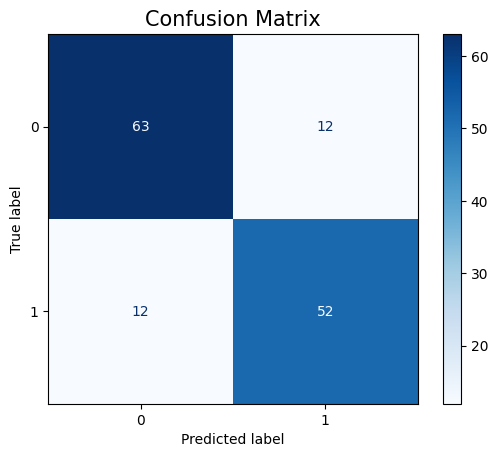

In [25]:
# Plotting the confusion matrix
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', size=15)
plt.show()

AUC: 0.8845


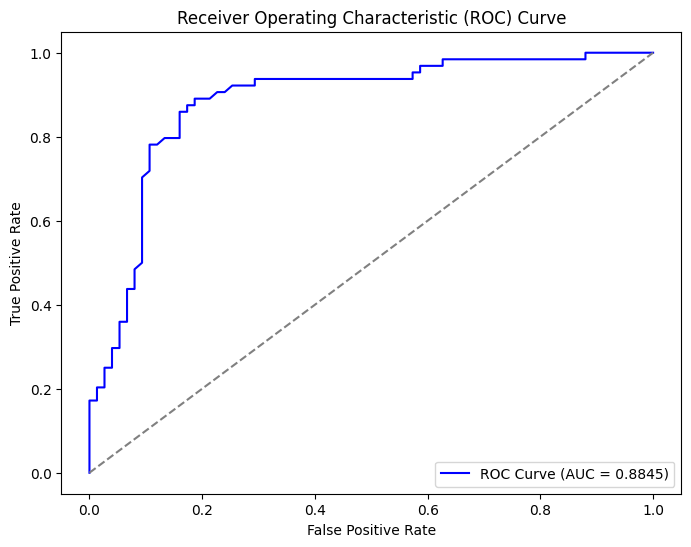

In [26]:
# Get the predicted probabilities for the ROC curve and AUC
y_prob = reg.predict_proba(x_test)[:, 1]  # Get probabilities for the positive class (class 1)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Print AUC score
print(f"AUC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()